In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, minimize_scalar
from statistics import mean
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# CEV Model
$$
dS_t = \mu S_t \, dt + \sigma S_t^\gamma \, dW_t
$$

In [2]:
data = pd.read_csv('../data/processed/training_prices.csv', index_col= 'Date', parse_dates= True)
days_trading = 252
r = 0.02
T = 1 # Time window for simulation
steps = len(data.iloc[:, 0])
Npaths = 10000

In [3]:
def CEV_path_simulation_mean(S, T, mu, sigma, gamma, steps, Npaths):
    dt = T / steps
    sqrt_dt = np.sqrt(dt)
    z = np.random.normal(size=(Npaths, steps))
    res = np.zeros((steps, Npaths))
    res[0, :] = S
    for time in range(1, steps):
        S_time = res[time - 1, :]
        res[time, :] = S_time * (1 + mu * dt) + sigma * S_time**gamma * z[:, time] * sqrt_dt
    return res.mean(axis=1)

# Objective function for minimizing
def CEV_objective(gamma, prices_mkt, S0, mu, sigma, steps, Npaths):
    prices_simu = CEV_path_simulation_mean(S0, T, mu, sigma, gamma, steps, Npaths)
    error = np.linalg.norm(prices_mkt - prices_simu)
    return error

# Find optimal gamma for each stock
def find_optimal_gamma(stock_data, T, steps, Npaths):
    S0 = stock_data.iloc[0]
    prices_mkt = stock_data.dropna().values
    log_ret = np.log(stock_data / stock_data.shift(1)).dropna()
    mu = np.nanmean(log_ret) * 252
    sigma = np.nanstd(log_ret) * np.sqrt(252)
    result = minimize_scalar(CEV_objective, bounds=(0, 1), args=(prices_mkt, S0, mu, sigma, steps, Npaths), method='bounded')
    return result.x

# Compute gamma for each stock
gammas = {}
for stock_name in data.columns:
    stock_data = data[stock_name]
    gammas[stock_name] = find_optimal_gamma(stock_data, T, steps, Npaths)
    print(f"Optimal gamma for {stock_name}: {gammas[stock_name]}")

Optimal gamma for AAPL: 0.3819660112501051
Optimal gamma for AMZN: 0.4643981834536242
Optimal gamma for EEM: 0.5925325870725705
Optimal gamma for GLD: 0.36700041969887454
Optimal gamma for JNJ: 0.45606826034726566
Optimal gamma for JPM: 0.23795816685915214
Optimal gamma for SPY: 0.24443861820264867
Optimal gamma for TSLA: 0.22335338897991236


In [4]:
# def CEV_path_simulation_mean(S, T, mu, sigma, gamma, steps, Npaths):
#     z = np.random.normal(size = Npaths*steps)
#     res = np.zeros((steps, Npaths))

#     dt = T/steps
#     sqrt_dt = dt ** 0.5
#     S0 = S
#     for path in range(Npaths):
#         res[0, path] = S0
#         for time in range(1, steps):
#             S_time = res[time-1, path]
#             S_temp = S_time + S_time * mu * dt + sigma * (S_time ** gamma) * z[path*steps + time] * sqrt_dt
#             res[time, path] = S_temp

#     paths_mean = res.mean(axis=1)

#     return paths_mean

# def CEV_objective(gamma, data, T, steps, Npaths):
#     total_err = 0
#     for stock_name in data.columns:
#         S0 = data[stock_name].iloc[0]
#         prices_mkt = data[stock_name].dropna().values
#         log_ret = np.log(data[stock_name] / data[stock_name].shift(1)).dropna()
#         mu = np.nanmean(log_ret) * 252
#         sigma = np.nanstd(log_ret) * np.sqrt(252)

#         prices_simu = CEV_path_simulation_mean(S0, T, mu, sigma, gamma, steps, Npaths)
#         error = np.linalg.norm(prices_mkt - prices_simu, 2)
#         total_err += error

#     return total_err

# def find_optimal_gamma(data, T, steps, Npaths):
#     result = minimize_scalar(CEV_objective, bounds=(0, 1), args=(data, T, steps, Npaths), method='bounded')
#     opt_gamma = result.x
#     return opt_gamma

In [5]:
# # Optimal gamma varies during different iterations, need further manipulation
# opt_gamma = find_optimal_gamma(data, T, steps, Npaths)
# print(f"Optimal gamma across all stocks: {opt_gamma}")

In [6]:
random.seed(10)
result_list = []

for i in range(len(data.columns)):
    stock_name = data.columns[i]
    stock = data[[stock_name]]
    
    # Simulate half of the entire time window to measure performance
    num_term = 0.5
    dayEnd_vol = int(num_term*days_trading)

    log_ret = (np.log(stock / stock.shift(1)))
    vol_daily = log_ret.std()
    vol_daily = vol_daily.to_list()[0]
    vol_yearly = round(vol_daily * 252 ** 0.5,5)

    ret_yearly = (stock.iloc[-1,0]/stock.iloc[0,0] - 1)
    ret_yearly = round(ret_yearly, 5)

    S0 = stock.iloc[0]
    Npaths = 1
    # opt_gamma = gammas[stock_name]
    opt_gamma = 0.8
    prices_simu = CEV_path_simulation_mean(S0, T, ret_yearly, vol_yearly, opt_gamma, steps, Npaths)
    log_ret = np.log(pd.Series(prices_simu) /pd.Series(prices_simu).shift(1))
    mu_simu = np.nanmean(log_ret) * 252
    mu_simu = round(mu_simu, 5)

    sigma_simu = np.nanstd(log_ret) * 252**0.5
    sigma_simu = round(sigma_simu,5)

    result_list.append([stock_name, ret_yearly, vol_yearly, mu_simu, sigma_simu])

In [7]:
# Test Result, we can see that variance varies, weird
result_list

[['AAPL', 0.54798, 0.19922, 0.55536, 0.07491],
 ['AMZN', 0.77045, 0.32921, 0.83369, 0.12263],
 ['EEM', 0.08036, 0.15485, 0.08396, 0.07252],
 ['GLD', 0.11756, 0.13372, 0.10888, 0.04665],
 ['JNJ', -0.09368, 0.16522, -0.22919, 0.06049],
 ['JPM', 0.29641, 0.20755, 0.18362, 0.07236],
 ['SPY', 0.26709, 0.13081, 0.20297, 0.03626],
 ['TSLA', 1.29861, 0.52387, 1.45575, 0.18669]]

In [8]:
def CEV_path_simulation(S, T, mu, sigma, gamma, steps, Npaths):

    gaussian_increments = np.random.normal(size = Npaths*steps)
    res = np.zeros((steps, Npaths))

    dt = T/steps
    sqrt_dt = dt ** 0.5
    S0 = S
    for path in range(Npaths):
        res[0, path] = S0
        for time in range(1, steps):
            S_time = res[time-1, path]
            S_temp = S_time + S_time * mu * dt + sigma * (S_time ** gamma) * gaussian_increments[path*steps + time] * sqrt_dt
            res[time, path] = S_temp

    return res

[]

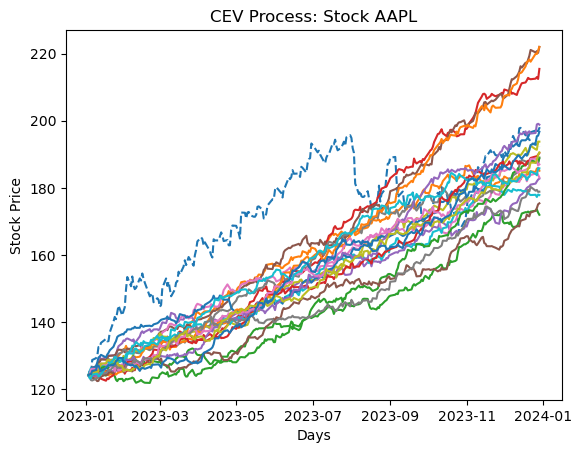

In [9]:
## Plot AAPL as an example
stock_name = data.columns[0]
stock = data[[stock_name]]

startstate = stock.iloc[0,0]

prices = stock
log_ret = np.log(prices /prices.shift(1))
vol_daily = log_ret.std().tolist()[0]
vol_yearly = round(vol_daily * 252 ** 0.5,5)

ret_yearly = np.nanmean(log_ret) * 252

mean = ret_yearly
vol = vol_yearly
Npaths = 20
prices_simu = CEV_path_simulation(startstate, T, mean, vol, 0.8, steps, Npaths)
prices_simu = pd.DataFrame(prices_simu, index= data.index)

plt.plot(stock, linestyle = '--')
plt.plot(prices_simu)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('CEV Process: Stock {}'.format(stock_name))
plt.plot()

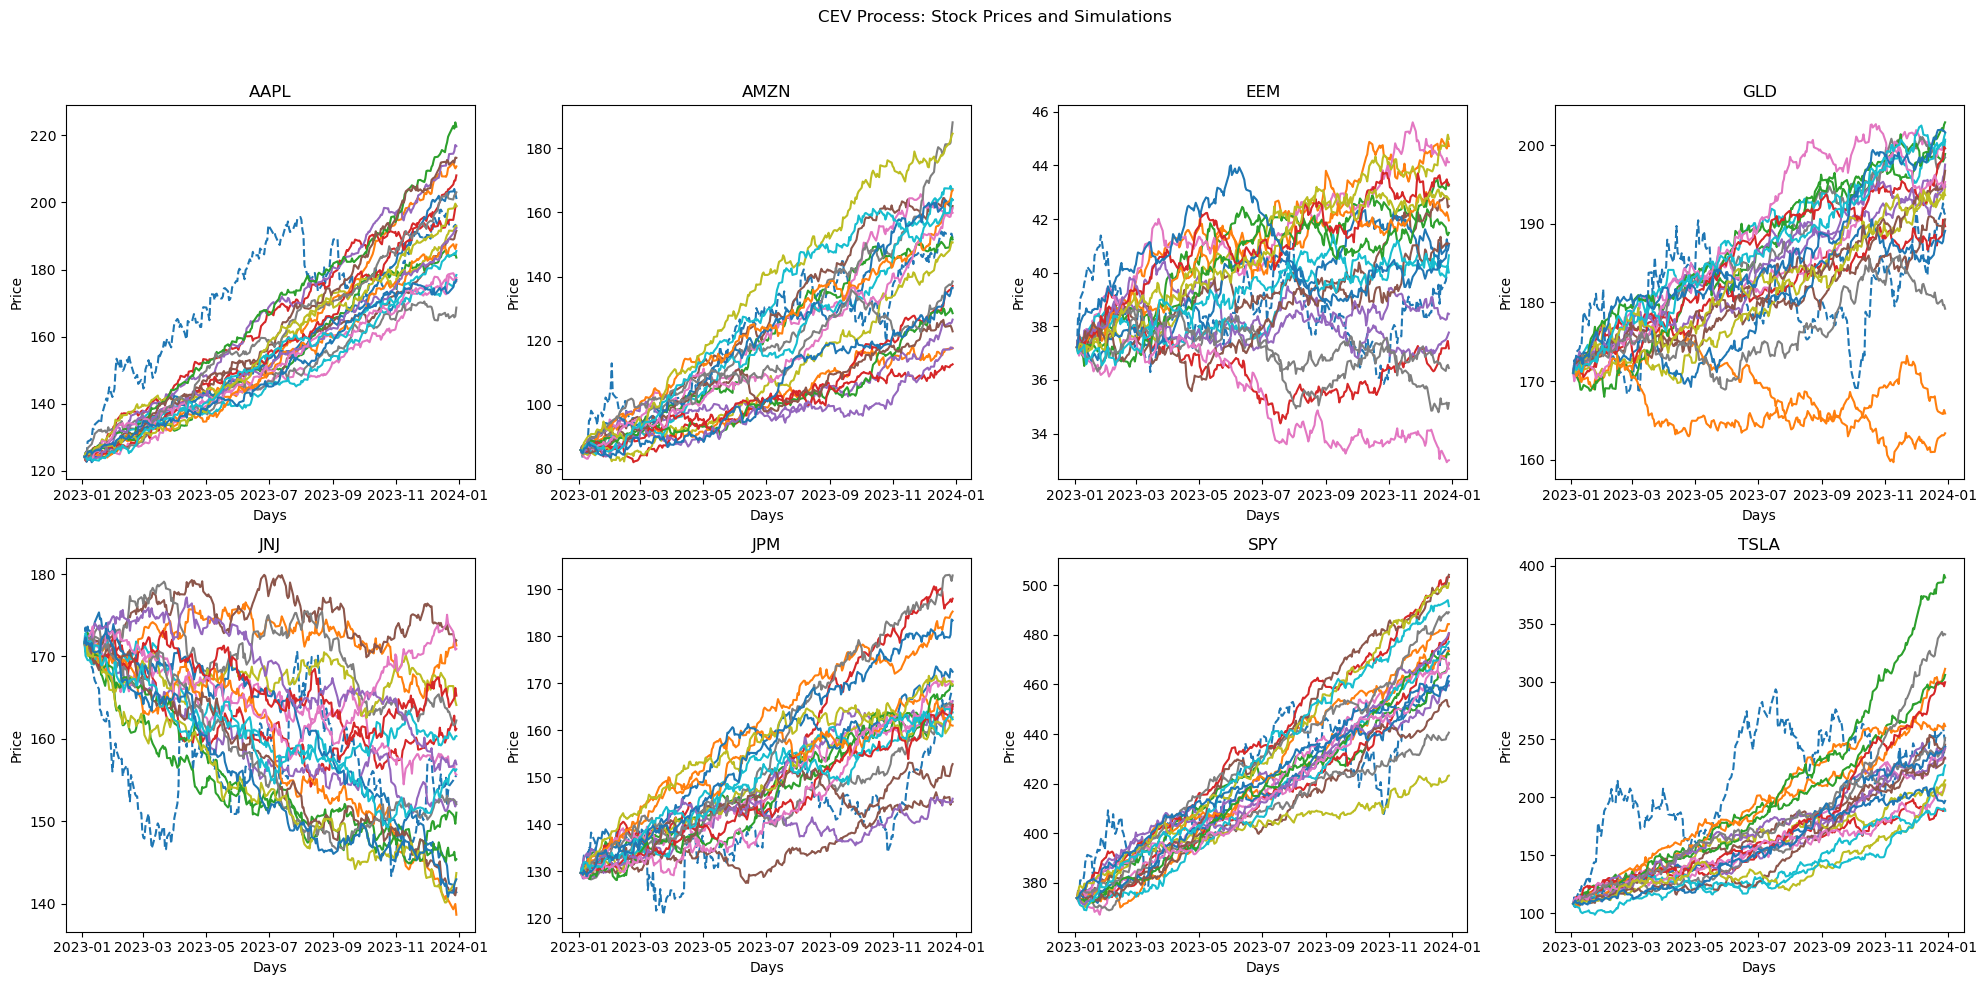

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('CEV Process: Stock Prices and Simulations')


for i, stock_name in enumerate(data.columns):
    row = i // 4
    col = i % 4

    stock = data[[stock_name]]

    startstate = stock.iloc[0,0]

    prices = stock
    log_ret = np.log(prices /prices.shift(1))
    vol_daily = log_ret.std().tolist()[0]
    vol_yearly = round(vol_daily * 252 ** 0.5,5)

    ret_yearly = np.nanmean(log_ret) * 252
        
    mean = ret_yearly
    vol = vol_yearly
    Npaths = 20
    prices_simu = CEV_path_simulation(startstate, T, mean, vol, 0.8, steps, Npaths)
    # prices_simu = CEV_path_simulation_mean(startstate, T, mean, vol, gammas[stock_name], steps, Npaths = 1000)
    prices_simu = pd.DataFrame(prices_simu, index= data.index)

    axs[row, col].plot(stock, linestyle='--', label='Actual Price')
    axs[row, col].plot(prices_simu, label='CEV Simulation')
    axs[row, col].set_title(stock_name)
    axs[row, col].set_xlabel('Days')
    axs[row, col].set_ylabel('Price')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()